# EDA on Targets

## Loading Datasets

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import matplotlib.dates as mdates

# Ex: load all parquet files from fold=0
fold_path = "./MDB_Attrition/data/targets/fold=0"

df = pd.read_parquet(fold_path)
print(df.shape)

(243936, 8)


In [2]:
df.head()

,client_id,mon,target_1,target_2,target_3,target_4,trans_count,diff_trans_date
0,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-02-28,0,0,0,0,10,0.0
1,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-03-31,0,0,0,0,29,0.0
2,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-04-30,0,0,0,0,51,0.0
3,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-05-31,0,0,0,0,52,4.0
4,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-06-30,0,0,0,0,52,35.0


In [3]:
# combine multiple folds

base_path = "/Users/debbiedai/Desktop/MDB_Attrition/data/targets"

dfs = []
for fold in range(5):  # fold=0 … fold=4
    fold_path = os.path.join(base_path, f"fold={fold}")
    df_fold = pd.read_parquet(fold_path)
    df_fold["fold"] = fold
    dfs.append(df_fold)

df = pd.concat(dfs, ignore_index=True)
print(df.shape)
df.sample(10)

(1202688, 9)


,client_id,mon,target_1,target_2,target_3,target_4,trans_count,diff_trans_date,fold
1191933,81343be8cee54e460123d4e5ba3d7f22c755ca0389d671...,2022-11-30,0,0,0,0,27,11.0,4
659882,4c01ddc6f9451173c28ff21d3a9147e8bcc95ef308c792...,2022-04-30,0,0,0,0,7,6.0,2
1175264,e95deb4a5d25f5a9cbf0709f69823f2c7fe731db346a67...,2022-10-31,0,0,0,0,15,11.0,4
837951,929f175447f5dda877057ba04c30430787b50dfe1456df...,2022-05-31,0,0,0,0,96,2.0,3
1123514,f01e408b65e1d647aa2263203bf65daf4c365515f5fcc8...,2022-04-30,0,0,0,0,6,13.0,4
516977,d726ee3328de32471d47dc6672738d9077d0b73627f170...,2022-07-31,0,0,0,0,2,117.0,2
443852,3c26088949131248d0dfa87dbf556c755582ab50b22fe6...,2022-10-31,0,0,0,0,241,0.0,1
8288,2af09de2658bd7a44b815e1450a58e983fb40d66378c16...,2022-10-31,0,0,0,0,194,5.0,0
612452,3acb648d4075b837a315fbc3d54b7bffdf8563c35e7bae...,2022-10-31,0,0,0,0,10,18.0,2
891662,d12961db802bb3f3fb82a077c7e899762e4c38434f256b...,2022-04-30,0,0,0,0,80,3.0,3


In [4]:
df.to_csv(
    'target.csv',
    index=False,
    date_format='%Y-%m-%d',
    float_format='%.6g',
    encoding='utf-8'
)

In [5]:
df['mon'].min(), df['mon'].max()

('2022-02-28', '2023-01-31')

### Schema and missing check

In [6]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202688 entries, 0 to 1202687
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   client_id        1202688 non-null  object 
 1   mon              1202688 non-null  object 
 2   target_1         1202688 non-null  int32  
 3   target_2         1202688 non-null  int32  
 4   target_3         1202688 non-null  int32  
 5   target_4         1202688 non-null  int32  
 6   trans_count      1202688 non-null  int32  
 7   diff_trans_date  1081902 non-null  float64
 8   fold             1202688 non-null  int64  
dtypes: float64(1), int32(5), int64(1), object(2)
memory usage: 59.6+ MB


client_id               0
mon                     0
target_1                0
target_2                0
target_3                0
target_4                0
trans_count             0
diff_trans_date    120786
fold                    0
dtype: int64

In [7]:
print("unique client per fold:", df.groupby('fold')['client_id'].nunique())


print("client-mon duplicates:", df[['client_id','mon']].duplicated().sum())
# checks that each client has at most one record per month (violations can create leakage or double-counting).

df.groupby('client_id')['fold'].nunique().value_counts()  # expect all 1
# Verifies each client appears in exactly one fold

unique client per fold: fold
0    20328
1    19902
2    19917
3    20017
4    20060
Name: client_id, dtype: int64
client-mon duplicates: 0


fold
1    100224
Name: count, dtype: int64

### Target prevalence

duplicate (client_id, mon) rows: 0
          positive_rate
target_1       0.004458
target_2       0.000480
target_3       0.003767
target_4       0.002544


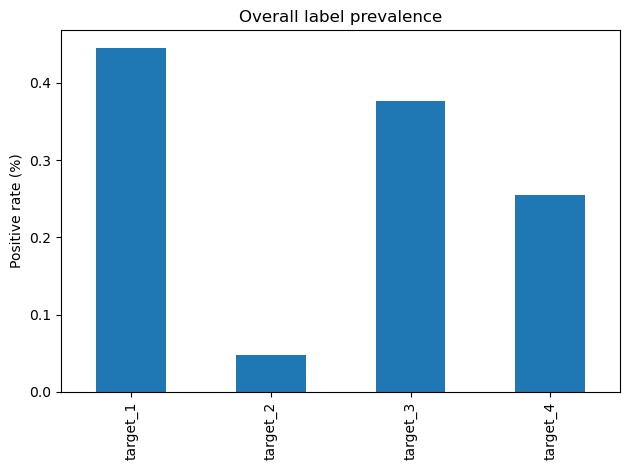

In [8]:
dups = df[df.duplicated(['client_id','mon'], keep=False)].sort_values(['client_id','mon'])
dup_count = len(dups)
print("duplicate (client_id, mon) rows:", dup_count)
# display(dups.head())  # uncomment in notebook if dup_count>0

# Label balance
targets = [f'target_{k}' for k in range(1,5)]
label_overall = df[targets].mean().rename('positive_rate').to_frame()
print(label_overall)


plt.figure()
(df[targets].mean()*100).plot(kind='bar')
plt.ylabel('Positive rate (%)')
plt.title('Overall label prevalence')
plt.tight_layout(); plt.show()


   fold    rows     mon_min     mon_max    rate_1    rate_2    rate_3  \
0     0  243936  2022-02-28  2023-01-31  0.004395  0.000541  0.003829   
1     1  238824  2022-02-28  2023-01-31  0.004451  0.000448  0.003819   
2     2  239004  2022-02-28  2023-01-31  0.004661  0.000485  0.003699   
3     3  240204  2022-02-28  2023-01-31  0.004184  0.000400  0.003872   
4     4  240720  2022-02-28  2023-01-31  0.004603  0.000523  0.003614   

     rate_4  
0  0.002599  
1  0.002450  
2  0.002536  
3  0.002585  
4  0.002551  


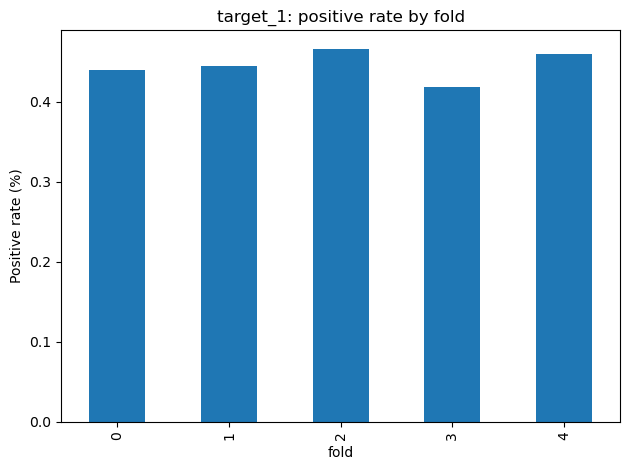

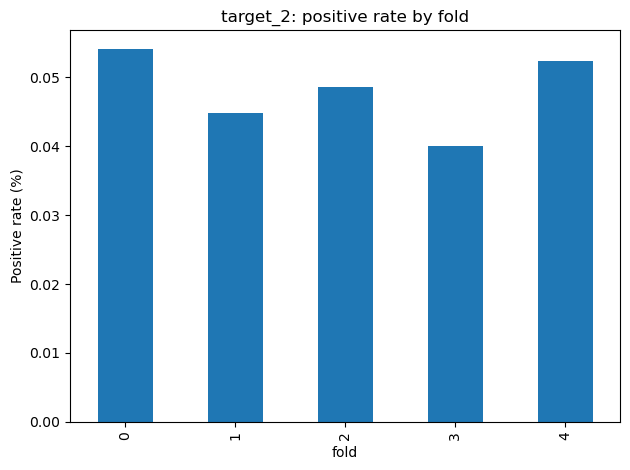

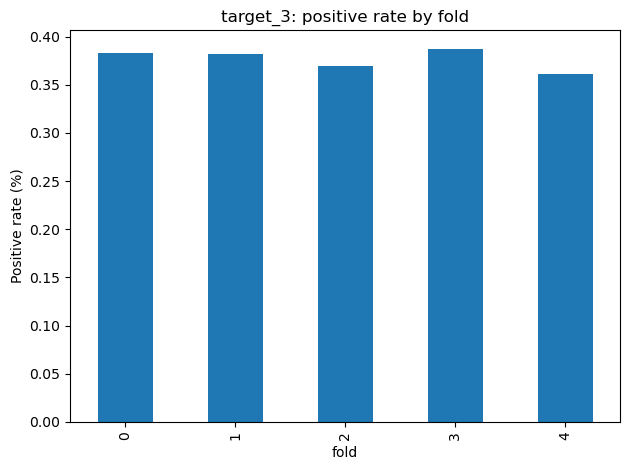

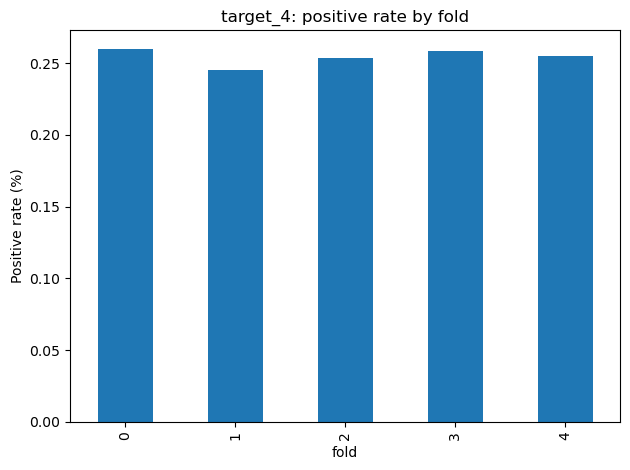

In [9]:
# per-fold label rates (one figure per target)
fold_summary = (
    df.groupby('fold', observed=True)
      .agg(rows=('client_id','count'),
           mon_min=('mon','min'),
           mon_max=('mon','max'),
           **{f'rate_{k}': (f'target_{k}', 'mean') for k in range(1,5)})
      .reset_index()
)
print(fold_summary)

fold_rates = df.groupby('fold', observed=True)[targets].mean()*100
for t in targets:
    plt.figure()
    fold_rates[t].plot(kind='bar')
    plt.ylabel('Positive rate (%)')
    plt.title(f'{t}: positive rate by fold')
    plt.tight_layout(); plt.show()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01'],
              dtype='datetime64[ns]', name='mon', freq='MS')


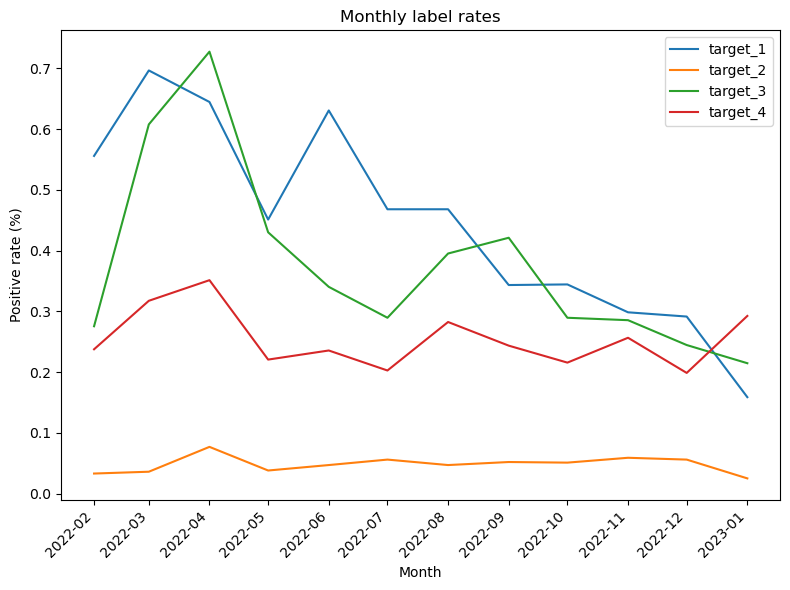

In [27]:
# plt.figure()
# monthly = df.groupby('mon', observed=True)[targets].mean()*100
# for t in targets:
#     plt.plot(monthly.index, monthly[t], label=t)
# plt.xlabel('Month'); plt.ylabel('Positive rate (%)')
# plt.title('Monthly label rates')
# plt.legend()
# plt.tight_layout(); plt.show()

print(type(monthly.index))
print(monthly.index[:5])


plt.figure(figsize=(8,6))

monthly = df.groupby('mon', observed=True)[targets].mean() * 100
monthly.index = (
    pd.to_datetime(monthly.index)
      .to_period('M')
      .to_timestamp(how='start')
)

for t in targets:
    plt.plot(monthly.index, monthly[t], label=t)

plt.xlabel('Month')
plt.ylabel('Positive rate (%)')
plt.title('Monthly label rates')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



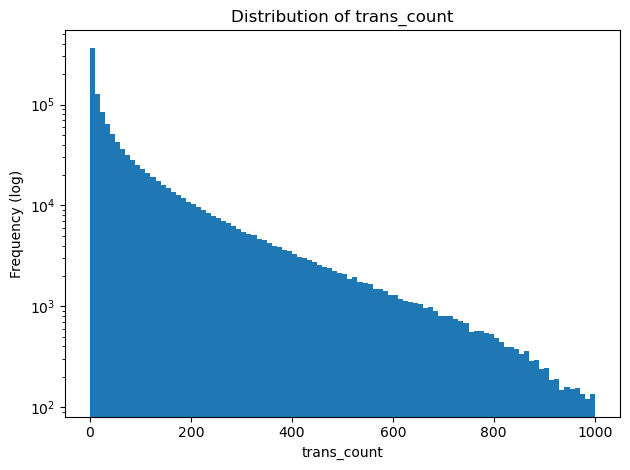

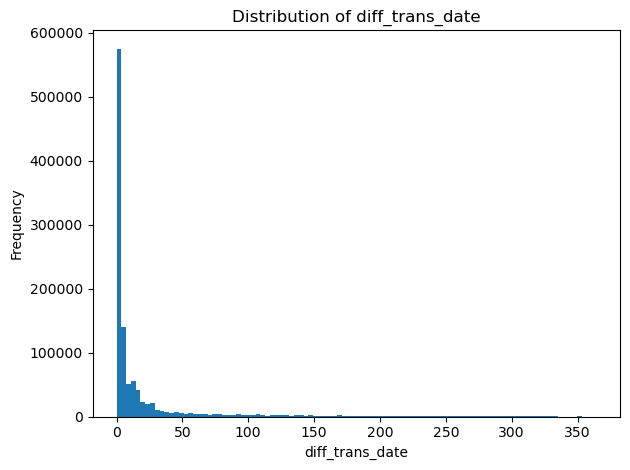

In [10]:
# trans_count histogram (log y to show tail)
plt.figure()
plt.hist(df['trans_count'].values, bins=100)
plt.yscale('log')
plt.xlabel('trans_count'); plt.ylabel('Frequency (log)')
plt.title('Distribution of trans_count')
plt.tight_layout(); plt.show()

# diff_trans_date histogram (drop NaN)
plt.figure()
plt.hist(df['diff_trans_date'].dropna().values, bins=100)
plt.xlabel('diff_trans_date'); plt.ylabel('Frequency')
plt.title('Distribution of diff_trans_date')
plt.tight_layout(); plt.show()


### Target correlation

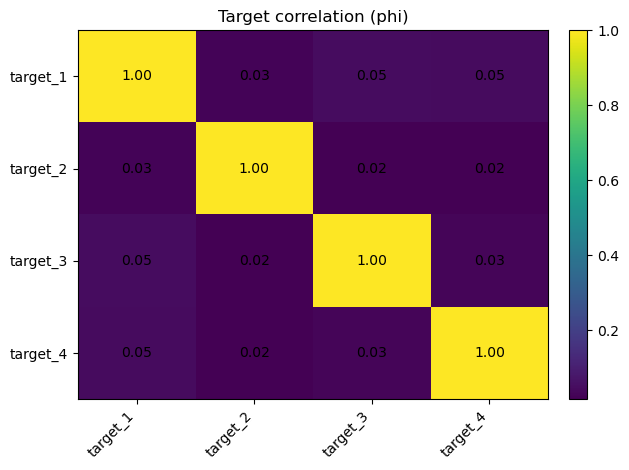

In [11]:
plt.figure()
phi = df[targets].corr(method='pearson')
im = plt.imshow(phi.values, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(targets)), targets, rotation=45, ha='right')
plt.yticks(range(len(targets)), targets)
plt.title('Target correlation (phi)')
# annotate
for i in range(phi.shape[0]):
    for j in range(phi.shape[1]):
        plt.text(j, i, f"{phi.values[i,j]:.2f}", ha='center', va='center')
plt.tight_layout(); plt.show()


In [29]:
df['client_id'].nunique()


100224